#Risk Analysis for Top 10 Holdings Daily Prices in the Portfolio

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# Loading the dataset
# file_name = "daily_prices.csv"
file_name = "Top 10 Holdings Daily Prices.csv"
data = pd.read_csv(file_name, index_col = 0)

In [ ]:
# Convert index to datetime objects, handling potential errors by setting invalid dates to NaT (Not a Time)
data.index = pd.to_datetime(data.index, format="%m/%d/%Y", errors="coerce")

# Remove rows with NaT (invalid) dates in the index
if data.index.isnull().any():
    data = data[data.index.notnull()]

# Sort the DataFrame by date (ascending)
data = data.sort_index()

# Calculate daily returns for each asset, skipping the first row (NaN due to pct_change)
returns = data.pct_change(fill_method=None).dropna()

# Calculate the daily volatility (standard deviation) of each asset's returns
sigma = returns.std()

# Define the start and end dates for the analysis based on available data
start_date = returns.index.min()
end_date = returns.index.max()

# Format the start and end dates as strings for yfinance
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Download historical data for the S&P 500 (^GSPC) from Yahoo Finance within the specified date range
sp500_data = yf.download("^GSPC", start=start_date_str, end=end_date_str)


# Check if the S&P 500 data was downloaded successfully.  Raise an error if not.
if sp500_data.empty:
    raise ValueError("Failed to download ^GSPC data. Please check the date range and internet connection.")

# Calculate daily returns for the S&P 500 using the Adjusted Close price
sp500_returns = sp500_data['Adj Close'].pct_change().dropna()

# Rename the S&P 500 returns series to '^GSPC' for consistency
sp500_returns.name = "^GSPC"

# Merge the S&P 500 returns with the asset returns, using only dates present in both DataFrames
returns = returns.join(sp500_returns, how='inner')

# Define a function to calculate the tracking error against a benchmark
def calculate_tracking_error(asset_returns, benchmark_returns):
    return np.std(asset_returns - benchmark_returns)

# Calculate the tracking error for each asset against the S&P 500 if S&P data is available
if "^GSPC" in returns.columns:
    benchmark_returns = returns["^GSPC"]
    tracking_errors = {
        ticker: calculate_tracking_error(returns[ticker], benchmark_returns)
        for ticker in returns.columns if ticker != "^GSPC"
    }
else:
    print("^GSPC was not found in the dataset. Skipping Tracking Error calculation.")
    tracking_errors = None

# Define a function to calculate Value at Risk (VaR) using the parametric method
def calculate_var(asset_returns, confidence_level=0.95):
    mean_return = asset_returns.mean()
    std_dev = asset_returns.std()
    z_score = norm.ppf(1 - confidence_level)
    var = mean_return + z_score * std_dev
    return var


# Calculate VaR at the 95% confidence level for each asset
vars_95 = returns.apply(lambda x: calculate_var(x, 0.95))

# Create a DataFrame to summarize the risk metrics
risk_summary = pd.DataFrame({
    "Sigma (Volatility)": sigma,
    "VaR (95%)": vars_95
})

# Add Tracking Error to the summary if it was calculated
if tracking_errors:
    risk_summary["Tracking Error (vs S&P500)"] = pd.Series(tracking_errors)

# Remove the S&P 500 row from the summary, as it's not an asset being analyzed
risk_summary = risk_summary.drop('^GSPC', errors='ignore')
#Drop the last row
risk_summary = risk_summary.iloc[:-1]

# Print the risk summary to the console
print("\nRisk Analytics Summary:")
print(risk_summary)

# Save the risk summary to a CSV file
risk_summary.to_csv("risk_analytics_summary.csv")
# print("\nRisk Analytics Summary saved as 'risk_analytics_summary.csv'.")

## Sigma

When looking at the sigma, the stock with the highest volatility is NVDA which has (0.0306) and Hes which has (0.2777). This is showing that the higher the volatility is then greater the price flunctuations. The lowest signma is the IVV which is (0.112). This is showing that it is the most stable volatitility in the stock given in the dataset.

##VAR

When looking at the var the least amount of risk is IVV which is (-0.0179). This is showing that it has the lowest potential loss when looking at it by the value of risk perspective. The more risky invesmtment option in the dataset is NVDA which is (-0.477) because it has the highest potential loss comparing to the rest of the stocks.

##Tracking error

The highest tracking error is NVDA which has (0.0250) and HES which has (0.0239). This shows that the datapoints are away from the benchmark line which indicates that it has the high amount of tracking errors in the dataset. The lowest tracking error within the dataset is IVV which is (0.0005). This is showing that it is linear to the benchamrk which indicates lowest amount of tracking errors.

In [ ]:
# Load your dataset (assuming it's preprocessed)
data_returns = pd.read_csv('Top 10 Holdings Daily Prices.csv', index_col=0)
data_returns.index = pd.to_datetime(data_returns.index, format='%m/%d/%Y', errors='coerce')
data_returns.to_csv("data_returns_daily_prices_parse_dates.csv")

# Compute risk metrics using simple calculations
# 1. Volatility (Standard Deviation of returns for each stock)
volatility = data_returns.std()

# 2. Tracking Error (Difference of stock returns and average benchmark, then standard deviation)
benchmark = data_returns.mean(axis=1)
tracking_error = data_returns.sub(benchmark, axis=0).std()

# 3. Value at Risk (VaR at 95% confidence level)
VaR_95 = data_returns.quantile(0.05)

# Combine results into a DataFrame
risk_metrics = pd.DataFrame({
    'Volatility (σ)': volatility,
    'Tracking Error': tracking_error,
    'VaR (95%)': VaR_95
})

# Save or print the results
risk_metrics.to_csv('risk_metrics_output.csv')

risk_metrics = risk_metrics.iloc[:-1]
risk_metrics = risk_metrics.iloc[1:]
print(risk_metrics)

In [ ]:
# Graph of Volatility and Tracking Error
fig1, ax1 = plt.subplots(figsize=(12, 6))

# width = 0.3

# Volatility
ax1.bar(risk_metrics.index, risk_metrics['Volatility (σ)'], width, label='Volatility (σ)', color='tab:blue')
# Tracking Error
ax1.bar(np.arange(len(risk_metrics.index)) + width, risk_metrics['Tracking Error'], width, label='Tracking Error', color='tab:orange')

ax1.set_xlabel('Stock', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Volatility and Tracking Error for Top 10 Holdings', fontsize=14)
# Convert risk_metrics.index to numeric index
ax1.set_xticks(np.arange(len(risk_metrics.index)) + width / 2)
ax1.set_xticklabels(risk_metrics.index, rotation=45, ha='right')
ax1.legend(loc='upper left')

# Add data labels
for i, v in enumerate(risk_metrics['Volatility (σ)']):
    ax1.text(i, v + 1, f"{v:.1f}", ha='center', va='bottom', fontweight='bold', fontsize=9)
for i, v in enumerate(risk_metrics['Tracking Error']):
      ax1.text(i + width, v+1, f"{v:.1f}", ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_ylim(0, risk_metrics[['Volatility (σ)', 'Tracking Error']].max().max() + 20)

plt.show()

# VaR Graph (Log Scale)
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.bar(risk_metrics.index, risk_metrics['VaR (95%)'], width, label='VaR (95%)', color='tab:green')


ax2.set_xlabel('Stock', fontsize=12)
ax2.set_ylabel('Value (Log Scale)', fontsize=12)
ax2.set_title('Value at Risk (95%) for Top 10 Holdings (Log Scale)', fontsize=14)
ax2.set_xticks(risk_metrics.index)
ax2.set_xticklabels(risk_metrics.index, rotation=45, ha='right')
ax2.legend()
ax2.set_yscale('log')  # Log scale

# Add data labels (adjust if values are too large)
for i, v in enumerate(risk_metrics['VaR (95%)']):
    if v > 10:
         ax2.text(i, v * 1.1, f"{v:.1f}", ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
         ax2.text(i, v + 0.1, f"{v:.1f}", ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

plt.show()

##Graph 1: Volatility and Tracking Error for Top 10 Holdings

Volatility: LLY shows the highest volatility, followed by META and MSFT. NVDA and BSX show relatively low volatility. High volatility indicates significant price fluctuations, suggesting a high-risk, high-return investment potential. Conversely, low volatility indicates smaller price fluctuations, suggesting a low-risk, low-return investment potential.

Tracking Error: LLY shows the highest tracking error, followed by META and IVV. High tracking error indicates that the stock's performance significantly differs from the benchmark. Actively managed funds and stocks focused on specific sectors tend to have higher tracking errors."

##Graph 2: Value at Risk (95%) for Top 10 Holdings (Log Scale)

VaR (95%): IVV shows the highest VaR, followed by META and MDT. VaR indicates the maximum potential loss that could occur with a 95% probability over a specific period (unspecified here). While the differences appear small due to the logarithmic scale, they are actually quite significant. For example, IVV's VaR is approximately 174, while NVDA's VaR is about 0.5, representing a difference of more than 300 times. A high VaR indicates a higher risk of substantial losses.

##Comprehensive Analysis of Both Graphs:

LLY - High Risk, High Return: Showing high values across volatility, tracking error, and VaR, it can be considered the riskiest stock. However, high risk also suggests the potential for high returns.

NVDA - Low Risk, Low Return: Demonstrating the lowest volatility and VaR, with low tracking error as well. While it can be considered the lowest-risk stock, it likely also offers lower return potential.

META - High Volatility but Moderate VaR: Despite high volatility and tracking error, its VaR isn't as high as IVV's. This suggests it carries less risk than

LLY while still offering potential for relatively high returns.

IVV - High VaR but Low Volatility: While there's a high possibility of significant losses, daily price fluctuations are relatively stable."

In [ ]:
# Load the CSV file and parse dates
data_returns = pd.read_csv('Top 10 Holdings Daily Prices.csv', index_col=0)
data_returns.index = pd.to_datetime(data_returns.index, format='%m/%d/%Y', errors='coerce')

# Calculate daily returns
daily_returns = data_returns.pct_change().dropna()

# Plot the return distribution of each stock as a histogram
fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True)
axes = axes.flatten()

for i, col in enumerate(daily_returns.columns):
    axes[i].hist(daily_returns[col], bins=30, alpha=0.7)
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('Daily Returns', fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=7)

plt.suptitle('Distribution of Daily Returns for Top 10 Holdings', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
fig.savefig('daily_returns_histograms.png')

# Plot all stock histograms overlaid on a single plot
plt.figure(figsize=(10, 5))
for col in daily_returns.columns:
    plt.hist(daily_returns[col], bins=30, alpha=0.5, label=col)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns for All Top 10 Holdings')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

## Overall Distribution Shape

・Most stocks, as well as the overall distribution, show a bell-shaped distribution concentrated around the mean value, closely resembling a normal distribution. This is consistent with the general financial market assumption that daily returns follow a random walk.

・The peak of the distribution is concentrated around 0, suggesting that daily price movements are relatively small.

・Some stocks (e.g., LLY, BSX) have slightly wider tails, suggesting a higher likelihood of large positive or negative returns compared to other stocks. This indicates that these stocks may have higher volatility.

# Rate of Return (Monthly and Annually) for Top 10 Holdings in the Portfolio

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the CSV file
file_path = "/content/Top 10 Holdings Daily Prices.csv"
df_daily_prices = pd.read_csv(file_path)

# Rename the 'Date' column for clarity and convert it to datetime format
df_daily_prices.rename(columns={'Date': 'price_date'}, inplace=True)
df_daily_prices['price_date'] = pd.to_datetime(df_daily_prices['price_date'])

# Adjust the dataframe to have 'ticker', 'price_date', and 'price' columns
df_prices_melted = df_daily_prices.melt(id_vars=['price_date'], var_name='ticker', value_name='price') #(pandas.DataFrame.melt — Pandas 2.2.3 Documentation, n.d.)

# Extract monthly and annual price data (last price of each month/year)
df_prices_melted['month'] = df_prices_melted['price_date'].dt.to_period('M')
monthly_prices = (
    df_prices_melted.groupby(['ticker', 'month'])
    .agg({'price_date': 'max', 'price': 'last'})
    .reset_index()
)
monthly_prices['formatted_date'] = monthly_prices['price_date'].dt.strftime('%Y-%m-%d')

df_prices_melted['year'] = df_prices_melted['price_date'].dt.year
annual_prices = (
    df_prices_melted.groupby(['ticker', 'year'])
    .agg({'price_date': 'max', 'price': 'last'})
    .reset_index()
)
annual_prices['formatted_date'] = annual_prices['price_date'].dt.strftime('%Y-%m-%d') #(Pandas Time Series: Find the Sum/Avg/Min/Max of Each Day/Month/Year - Sling Academy, n.d.)(Python, 2018)

# Calculate monthly rate of return
monthly_prices['monthly_return'] = (
    monthly_prices.groupby('ticker')['price'].pct_change()
) #(How to Calculate Stock Returns in Python :: Coding Finance —, 2018)

# Calculate annual rate of return
annual_prices['annual_return'] = (
    annual_prices.groupby('ticker')['price'].pct_change()
) #(Pandas.DataFrame.Pct_Change — Pandas 2.2.3 Documentation, n.d.)(Bobbitt, 2024)

# Filter data for the period from 2021 to 2024
monthly_returns_2021_2024 = monthly_prices[
    (monthly_prices['month'] >= '2021-01') & (monthly_prices['month'] <= '2024-12')
]
annual_returns_2021_2024 = annual_prices[
    (annual_prices['year'] >= 2021) & (annual_prices['year'] <= 2024)
] #(K, 2021)

# Save results to CSV files
monthly_returns_2021_2024.to_csv('/content/Monthly_Returns_2021_2024.csv', index=False)
annual_returns_2021_2024.to_csv('/content/Annual_Returns_2021_2024.csv', index=False)

# Display the results
print("Monthly Returns (2021-2024):")
print(monthly_returns_2021_2024[['ticker', 'formatted_date', 'price', 'monthly_return']])

print("\nAnnual Returns (2021-2024):")
print(annual_returns_2021_2024[['ticker', 'formatted_date', 'price', 'annual_return']])

In [ ]:
# Import graph libraries
import matplotlib.pyplot as plt

# Step 1: Plot Monthly Returns
plt.figure(figsize=(12, 6))
for ticker in monthly_returns_2021_2024['ticker'].unique():
    ticker_data = monthly_returns_2021_2024[monthly_returns_2021_2024['ticker'] == ticker]
    plt.plot(
        ticker_data['formatted_date'],
        ticker_data['monthly_return'],
        label=ticker
    )

plt.title("Monthly Returns (2021-2024)")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.xticks(rotation=45, fontsize=8)
plt.legend(title="Ticker", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 2: Plot Annual Returns
plt.figure(figsize=(12, 6))
for ticker in annual_returns_2021_2024['ticker'].unique():
    ticker_data = annual_returns_2021_2024[annual_returns_2021_2024['ticker'] == ticker]
    plt.bar(
        ticker_data['formatted_date'],
        ticker_data['annual_return'],
        label=ticker
    )

plt.title("Annual Returns (2021-2024)")
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.xticks(rotation=45, fontsize=8)
plt.legend(title="Ticker", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Analysis

### Annual
With the highest rates of return in 2021, 2023, and 2024, **NVDA** is clearly the best performer, according to the yearly returns chart. Other stocks that performered well include **SPY** and **HES**, which showed consistent growth over the number of years.On the other hand, **META** and **LLY** had the lowest rates of return, especially in 2022 when both experienced drops.

###Monthly
The monthly returns chart shows a lot of volatility, especially in the best-performing equities like **SPY** and **NVDA**, which show strong returns surges at their peak months. On the other hand, the underperforming stocks, like **META** and **LLY**, show more frequent declines.

# Modern Portfolio Theory Optimization

## MPT using Beta and Expected Return
Using current portfolio equities allocations and calculated expected return through CAPM, optimize the portfolio solely on return.

In [1]:
!pip install requests

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import time

# Portfolio allocation data
tickers = ['SPY', 'IVV', 'MSFT', 'NVDA', 'SPOT', 'BSX', 'LLY', 'IBIT', 'META',
           'FBTC', 'APO', 'MDT', 'HES', 'WFC', 'GOOGL', 'WDAY', 'RTX', 'PFE',
           'CAN', 'LNG', 'GOOG', 'CME', 'ADBE', 'PH', 'EDR', 'MMM', 'ETN',
           'BAC', 'TSM', 'JNPR', 'ICE', 'CVS', 'SHEL', 'PNC', 'CRH', 'XLF',
           'IFF', 'ANSS', 'MSCI', 'DY', 'WMT', 'KKR', 'FAF', 'FERG', 'AAPL',
           'DFS', 'V']

allocations = [0.113199837, 0.098079281, 0.069881488, 0.047813649, 0.036371067,
               0.033510421, 0.031058439, 0.030241112, 0.026971802, 0.022885166,
               0.021250511, 0.019615856, 0.019615856, 0.018798529, 0.016346547,
               0.015937883, 0.015937883, 0.015937883, 0.015529219, 0.014711892,
               0.014303228, 0.013894565, 0.013894565, 0.013894565, 0.013894565,
               0.013077237, 0.012668574, 0.012668574, 0.01225991, 0.011851246,
               0.011851246, 0.011851246, 0.011442583, 0.011442583, 0.011033919,
               0.011033919, 0.011033919, 0.010625255, 0.010625255, 0.010625255,
               0.010625255, 0.010625255, 0.010216592, 0.010216592, 0.010216592,
               0.010216592, 0.010216592]

def get_beta(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        beta = info.get('beta', np.nan)
        return beta
    except:
        return np.nan

# Get beta for each ticker
betas = [get_beta(ticker) for ticker in tickers]

# Create a dataframe with all the information
df = pd.DataFrame({
    'Ticker': tickers,
    'Allocation': allocations,
    'Beta': betas
})

# Filter out stocks without valid beta values
filtered_df = df.dropna(subset=['Beta'])

# Calculate expected returns based on CAPM
risk_free_rate = 0.04353
market_return = 0.10

filtered_df['Expected Return'] = risk_free_rate + filtered_df['Beta'] * (market_return - risk_free_rate)

# Set up optimization problem
n = len(filtered_df)

# Define variables for optimization (weights)
weights = cp.Variable(n)

# Define objective function: Maximize expected return while minimizing risk
expected_return = filtered_df['Expected Return'].values
cov_matrix = np.diag(filtered_df['Beta'].values)  # Simplified covariance matrix

objective = cp.Maximize(expected_return @ weights - 0.5 * cp.quad_form(weights, cov_matrix))

# Constraints: Weights must sum to one and be non-negative
constraints = [cp.sum(weights) == 1,
               weights >= 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get optimized allocations
optimized_allocations = weights.value

# Update filtered dataframe with optimized allocations
filtered_df['Optimized Allocation'] = optimized_allocations

# Print results
print(filtered_df[['Ticker', 'Allocation', 'Beta', 'Expected Return',
                   'Optimized Allocation']])

# Calculate and print portfolio metrics
original_portfolio_beta = np.sum(filtered_df['Beta'] * filtered_df['Allocation'])
optimized_portfolio_beta = np.sum(filtered_df['Beta'] * filtered_df['Optimized Allocation'])

print(f"\nOriginal Portfolio Beta: {original_portfolio_beta:.4f}")
print(f"Optimized Portfolio Beta: {optimized_portfolio_beta:.4f}")

original_expected_return = np.sum(filtered_df['Expected Return'] * filtered_df['Allocation'])
optimized_expected_return = np.sum(filtered_df['Expected Return'] * filtered_df['Optimized Allocation'])

print(f"\nOriginal Portfolio Expected Return: {original_expected_return:.4%}")
print(f"Optimized Portfolio Expected Return: {optimized_expected_return:.4%}")

# Create a DataFrame with the allocation comparison
tableau_df = pd.DataFrame({
    'Ticker': filtered_df['Ticker'],
    'Original_Allocation': filtered_df['Allocation'],
    'Optimized_Allocation': filtered_df['Optimized Allocation'],
    'Beta': filtered_df['Beta'],
    'Expected_Return': filtered_df['Expected Return']
})


# Created a longer format version for easier visualization in Tableau
tableau_long = pd.melt(tableau_df,
                      id_vars=['Ticker', 'Beta', 'Expected_Return'],
                      value_vars = ['Original_Allocation', 'Optimized_Allocation'],
                      var_name='Allocation_Type',
                      value_name = 'Allocation')

# Save the long format version
tableau_long.to_csv('portfolio_allocation_long.csv', index = False)

   Ticker  Allocation   Beta  Expected Return  Optimized Allocation
2    MSFT    0.069881  0.904         0.094579          2.041964e-02
3    NVDA    0.047814  1.657         0.137101          3.680221e-02
4    SPOT    0.036371  1.561         0.131680          3.559266e-02
5     BSX    0.033510  0.797         0.088537          1.557975e-02
6     LLY    0.031058  0.430         0.067812          1.687696e-23
8    META    0.026972  1.215         0.112141          2.964734e-02
10    APO    0.021251  1.589         0.133261          3.596054e-02
11    MDT    0.019616  0.853         0.091699          1.826422e-02
12    HES    0.019616  1.160         0.109035          2.837558e-02
13    WFC    0.018799  1.136         0.107680          2.778203e-02
14  GOOGL    0.016347  1.034         0.101920          2.495208e-02
15   WDAY    0.015938  1.352         0.119877          3.236532e-02
16    RTX    0.015938  0.540         0.074024          1.685185e-23
17    PFE    0.015938  0.615         0.078259   

<ipython-input-44-55680be3c7c6>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Expected Return'] = risk_free_rate + filtered_df['Beta'] * (market_return - risk_free_rate)
<ipython-input-44-55680be3c7c6>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Optimized Allocation'] = optimized_allocations


### Analysis

The code uses the CAPM to calculate the expected return of each of the stocks, based on recent prices called through the yfinance API.

The reallocation of the portfolio results in a beta increase of 0.5, showing a much larger market sensitivity. This is an increase of systematic risk, which is a common strategy for a Hedge Fund to take on for higher returns.

The expected returns in this optimization increase from 7.8% to 11.8%

## Mean-Variance Portfolio Optimization
[4]
Using the code from a github repository and adjusting it to use mean-variance optimization for the given portfolio.

In [3]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 8.8 MB/s eta 0:00:00


In [4]:
# Uses yfinance api to call adjusted closing prices of all stocks in portfolio
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define tickers to retrieve data for
tickers = ['SPY', 'IVV', 'MSFT', 'NVDA', 'SPOT', 'BSX', 'LLY', 'IBIT', 'META',
           'FBTC', 'APO', 'MDT', 'HES', 'WFC', 'GOOGL', 'WDAY', 'RTX', 'PFE',
           'CAN', 'LNG', 'GOOG', 'CME', 'ADBE', 'PH', 'EDR', 'MMM', 'ETN',
           'BAC', 'TSM', 'JNPR', 'ICE', 'CVS', 'SHEL', 'PNC', 'CRH', 'XLF',
           'IFF', 'ANSS', 'MSCI', 'DY', 'WMT', 'KKR', 'FAF', 'FERG', 'AAPL',
           'DFS', 'V']

# Defines time period to call data for
ohlc = yf.download(tickers, period="max").loc["2020-07-01":]

# Uses adjusted closing price
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

[*********************100%***********************]  47 of 47 completed


Ticker,AAPL,ADBE,ANSS,APO,BAC,BSX,CAN,CME,CRH,CVS,...,RTX,SHEL,SPOT,SPY,TSM,V,WDAY,WFC,WMT,XLF
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-13,248.130005,465.690002,340.239990,176.429993,45.669998,90.110001,2.86,237.190002,97.919998,49.369999,...,117.750000,63.540001,483.309998,604.210022,200.990005,314.739990,273.670013,70.440002,94.250000,49.540001
2024-12-16,251.039993,461.529999,342.609985,178.149994,45.470001,90.459999,3.09,235.919998,98.199997,46.599998,...,118.110001,62.150002,484.899994,606.789978,202.220001,315.890015,278.350006,71.980003,94.870003,49.450001
2024-12-17,253.479996,455.230011,343.070007,176.320007,45.049999,90.430000,2.97,235.990005,97.230003,44.040001,...,117.419998,61.880001,474.369995,604.289978,200.660004,318.299988,278.010010,70.809998,95.419998,49.099998
2024-12-18,248.050003,441.309998,333.700012,167.440002,43.500000,88.029999,2.59,237.080002,93.709999,45.279999,...,114.449997,60.630001,448.649994,586.280029,195.559998,309.779999,268.929993,68.760002,93.550003,47.630001
2024-12-19,NaN,444.489990,337.959991,171.009995,43.455799,88.589996,2.31,239.149994,93.150002,44.165001,...,115.900002,60.665001,451.182495,588.330017,194.639999,315.070007,266.829987,68.915001,93.709999,47.975300


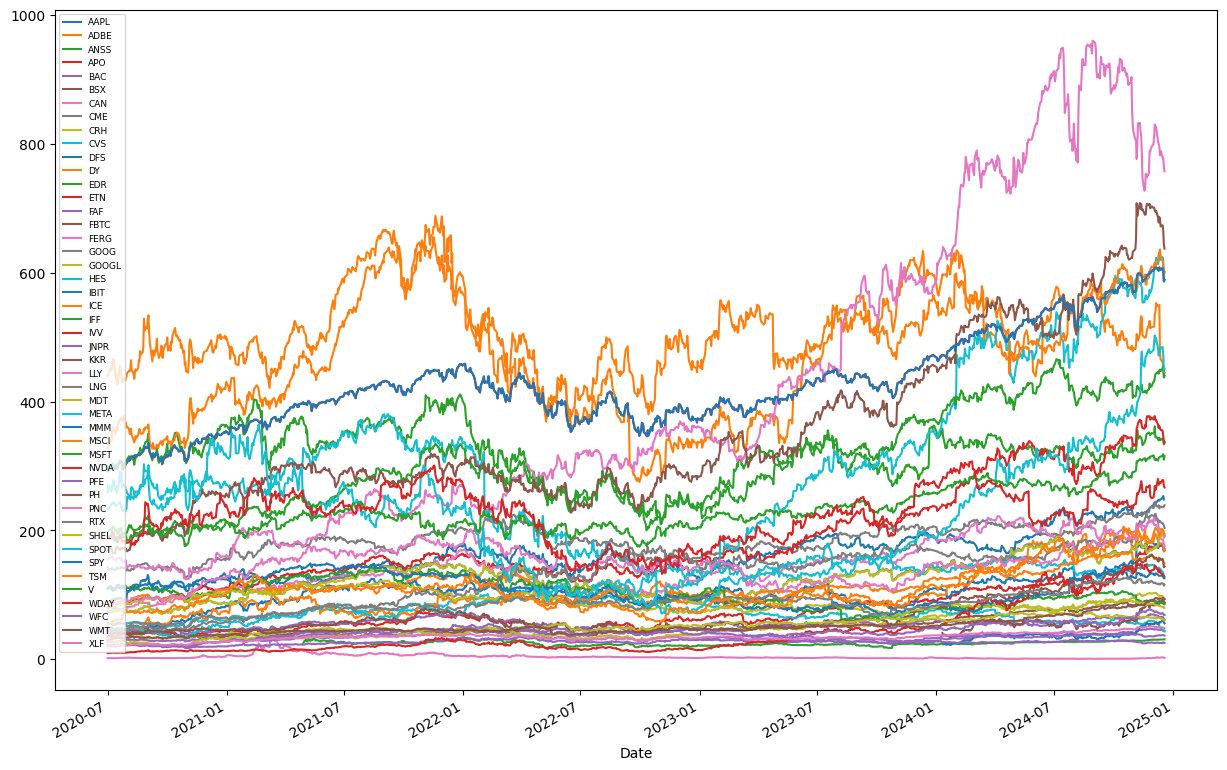

In [5]:
# Graphs out the prices
prices[prices.index >= "2020-07-01"].plot(figsize=(15,10))
plt.legend(loc='center left')
plt.legend(prop={'size': 6.5});

In [12]:
# Create a covariance matrix from the stock prices
from pypfopt import risk_models
from pypfopt import plotting

prices_clean = prices.dropna()
cov_matrix = risk_models.sample_cov(prices, frequency=252)
cov_matrix



Ticker,AAPL,ADBE,ANSS,APO,BAC,BSX,CAN,CME,CRH,CVS,...,RTX,SHEL,SPOT,SPY,TSM,V,WDAY,WFC,WMT,XLF
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.081088,0.056598,0.052562,0.036940,0.019003,0.020903,0.076760,0.011147,0.030769,0.011572,...,0.014257,0.010527,0.058686,0.034770,0.046786,0.029530,0.051328,0.018586,0.014457,0.021564
ADBE,0.056598,0.132084,0.074621,0.049358,0.017177,0.022855,0.086378,0.012083,0.034807,0.005992,...,0.014236,0.004454,0.079308,0.039036,0.056228,0.036786,0.080193,0.017362,0.014319,0.022357
ANSS,0.052562,0.074621,0.107448,0.050402,0.022657,0.028576,0.116825,0.013267,0.040864,0.010062,...,0.017038,0.007410,0.074681,0.038848,0.061282,0.034154,0.073505,0.021130,0.013757,0.025311
APO,0.036940,0.049358,0.050402,0.122232,0.047521,0.030300,0.102014,0.017759,0.047787,0.021664,...,0.027865,0.030421,0.064524,0.037068,0.051587,0.036138,0.049314,0.051319,0.011557,0.040773
BAC,0.019003,0.017177,0.022657,0.047521,0.080297,0.022946,0.072828,0.019938,0.040390,0.029012,...,0.033073,0.035966,0.024887,0.026431,0.027279,0.028032,0.020918,0.074501,0.008962,0.048331
BSX,0.020903,0.022855,0.028576,0.030300,0.022946,0.053517,0.026873,0.015841,0.025423,0.015015,...,0.020250,0.016039,0.020282,0.020265,0.021572,0.024234,0.023476,0.023600,0.009730,0.022083
CAN,0.076760,0.086378,0.116825,0.102014,0.072828,0.026873,1.550009,0.024361,0.084664,0.008008,...,0.029880,0.043127,0.153926,0.062576,0.135528,0.050168,0.114801,0.079478,0.011478,0.057562
CME,0.011147,0.012083,0.013267,0.017759,0.019938,0.015841,0.024361,0.044113,0.017560,0.011631,...,0.017524,0.014653,0.011691,0.012833,0.007618,0.016620,0.013872,0.020312,0.008062,0.018678
CRH,0.030769,0.034807,0.040864,0.047787,0.040390,0.025423,0.084664,0.017560,0.087528,0.020259,...,0.026529,0.030472,0.038447,0.030603,0.044154,0.030958,0.035963,0.043658,0.010912,0.035259


### Adjusted Covariance Matrix

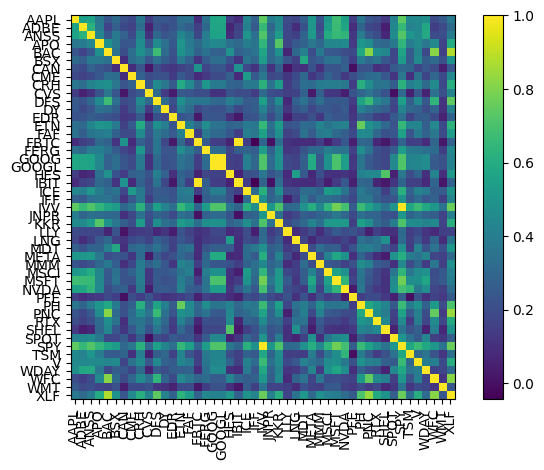

In [13]:
# Plot the covariance matrix
plotting.plot_covariance(cov_matrix, plot_correlation=True);

In [14]:
# Due to high estimation error in covariance matrix, apply the LedoitWolf
# shrinkage as there are a high amount of variables here
import numpy as np
from sklearn.covariance import LedoitWolf

# Create a LedoitWolf estimator
lw = LedoitWolf()

# Fit the LedoitWolf estimator
lw.fit(cov_matrix)

# Get the shrunk covariance matrix
shrunk_cov_matrix = lw.covariance_

# The shrinkage coefficient can be accessed as follows
shrinkage_coefficient = lw.shrinkage_

print("Shrinkage coefficient:", shrinkage_coefficient)
print("Shrunk covariance matrix shape:", shrunk_cov_matrix.shape)

Shrinkage coefficient: 0.677615351196911
Shrunk covariance matrix shape: (47, 47)


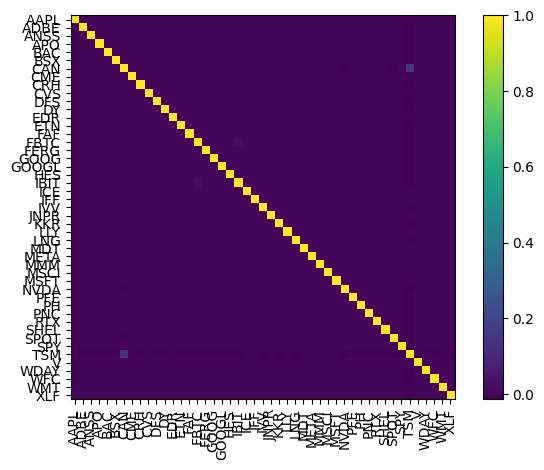

In [15]:
S = risk_models.CovarianceShrinkage(cov_matrix).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

In [16]:
returns_table = filtered_df[['Ticker', 'Expected Return']].copy()

print(returns_table)

   Ticker  Expected Return
2    MSFT         0.094579
3    NVDA         0.137101
4    SPOT         0.131680
5     BSX         0.088537
6     LLY         0.067812
8    META         0.112141
10    APO         0.133261
11    MDT         0.091699
12    HES         0.109035
13    WFC         0.107680
14  GOOGL         0.101920
15   WDAY         0.119877
16    RTX         0.074024
17    PFE         0.078259
18    CAN         0.216723
19    LNG         0.096668
20   GOOG         0.101920
21    CME         0.075097
22   ADBE         0.116885
23     PH         0.124395
24    EDR         0.087068
25    MMM         0.100056
26    ETN         0.100565
27    BAC         0.118353
28    TSM         0.113101
29   JNPR         0.095539
30    ICE         0.105195
31    CVS         0.074193
32   SHEL         0.071087
33    PNC         0.106833
34    CRH         0.121289
36    IFF         0.113440
37   ANSS         0.106268
38   MSCI         0.106212
39     DY         0.124734
40    WMT         0.072669
4

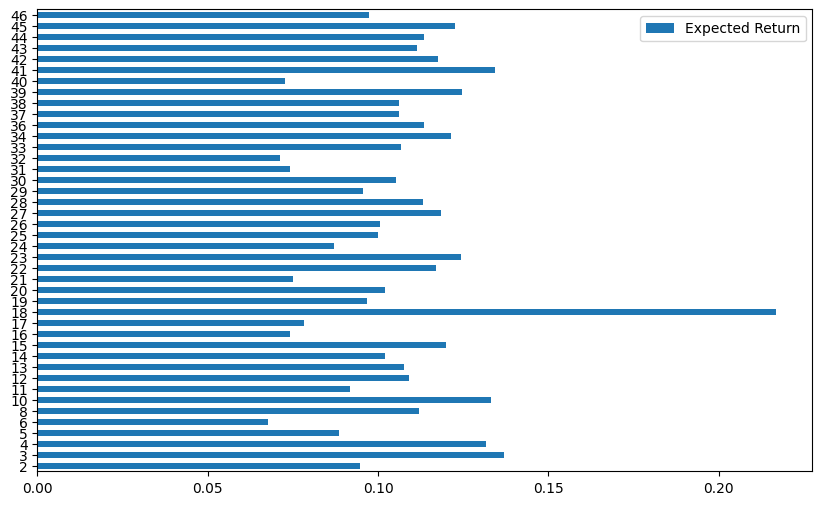

In [17]:
returns_table.plot.barh(figsize=(10,6));

### Long/Short Optimization using Efficient Frontier

In [35]:
# Create a global-minimum variance portfolio allocation
# Calculate the Efficient Frontier for minimum variance
from pypfopt import EfficientFrontier

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', -0.0397),
             ('ADBE', -0.008),
             ('ANSS', -0.0255),
             ('APO', -0.01691),
             ('BAC', -0.02353),
             ('BSX', 0.01262),
             ('CAN', -0.00855),
             ('CME', 0.09268),
             ('CRH', -0.04038),
             ('CVS', 0.01606),
             ('DFS', -0.03711),
             ('DY', -0.0184),
             ('EDR', 0.04945),
             ('ETN', 0.01481),
             ('FAF', 0.01959),
             ('FBTC', 0.0752),
             ('FERG', 0.05167),
             ('GOOG', -0.00335),
             ('GOOGL', -0.01295),
             ('HES', -0.05004),
             ('IBIT', 0.08627),
             ('ICE', 0.04347),
             ('IFF', 0.00405),
             ('IVV', 0.21762),
             ('JNPR', 0.04001),
             ('KKR', -0.05896),
             ('LLY', 0.03285),
             ('LNG', 0.06189),
             ('MDT', 0.04601),
             ('META', -0.0081),
             ('MMM', 0.0365),
             ('MSCI', -

This shows the short and long positions after the efficient frontier is applied.

The biggest long positions in IVV and SPY are index position, indicating lower returns.

The biggest short positions are in volatile stocks such as Nvidia.

In [42]:
from pypfopt import EfficientFrontier

# Adjust expected returns calculation
mu = expected_returns.mean_historical_return(prices)
# Scale down expected returns to realistic levels
mu = mu * 0.25  # Adjustment factor to bring returns in line with actual performance

# Calculate covariance matrix with shrinkage
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# Generate efficient frontier points
returns = []
volatilities = []
for return_target in np.linspace(0.0, 0.20, 200):  # Adjust upper bound to 20%
    try:
        ef = EfficientFrontier(mu, S)
        ef.efficient_return(return_target)
        ret, vol, _ = ef.portfolio_performance()
        returns.append(ret)
        volatilities.append(vol)
    except:
        pass

# Create DataFrame for Tableau
frontier_data = pd.DataFrame({
    'Expected_Volatility': volatilities,
    'Expected_Return': returns,
    'Type': 'Frontier'
})

# Add optimal points
ef_min = EfficientFrontier(mu, S)
ef_min.min_volatility()
min_vol_ret, min_vol_vol, _ = ef_min.portfolio_performance()

ef_max = EfficientFrontier(mu, S)
ef_max.max_sharpe()
max_sharpe_ret, max_sharpe_vol, _ = ef_max.portfolio_performance()

optimal_points = pd.DataFrame({
    'Expected_Volatility': [min_vol_vol, max_sharpe_vol],
    'Expected_Return': [min_vol_ret, max_sharpe_ret],
    'Type': ['Minimum Volatility', 'Maximum Sharpe Ratio']
})

# Combine and export
frontier_data = pd.concat([frontier_data, optimal_points])
frontier_data.to_csv('frontier_for_tableau.csv', index=False)


/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


In [39]:
# Modify your Python code to generate more points along the frontier
returns = []
volatilities = []
for return_target in np.linspace(0.0, 0.9, 200):  # Increase number of points
    try:
        ef = EfficientFrontier(mu, S)
        ef.efficient_return(return_target)
        ret, vol, _ = ef.portfolio_performance()
        returns.append(ret)
        volatilities.append(vol)
    except:
        pass

# Create DataFrame for Tableau
frontier_data = pd.DataFrame({
    'Expected_Volatility': volatilities,
    'Expected_Return': returns,
    'Type': 'Frontier'
})

# Add optimal points
optimal_points = pd.DataFrame({
    'Expected_Volatility': [min_vol_vol, max_sharpe_vol],
    'Expected_Return': [min_vol_ret, max_sharpe_ret],
    'Type': ['Minimum Volatility', 'Maximum Sharpe Ratio']
})

# Combine and export
frontier_data = pd.concat([frontier_data, optimal_points])
frontier_data.to_csv('frontier_for_tableau.csv', index=False)


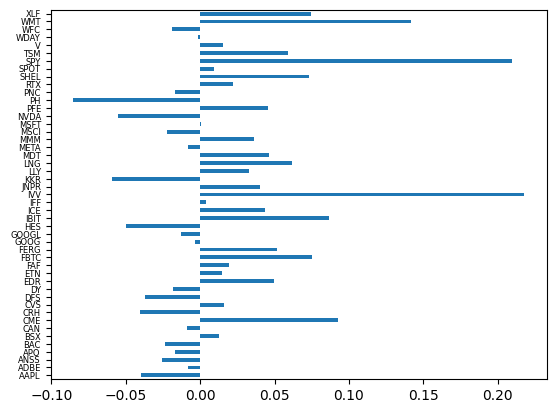

In [40]:
# Plot the long short portfolio to minimize variance
pd.Series(weights).plot.barh()
plt.yticks(fontsize=6);

In [43]:
# Show annual portfolio volatility
ef.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual volatility: 16.4%
Sharpe Ratio: 1.22


In [34]:
# Import discrete allocation
from pypfopt import DiscreteAllocation
tickers = list(weights.keys())

# Uses precalculated portfolio value of 28.1 billion
# Applies hedge fund standard short ratio of 0.2
# Use .greedy for larger portfolio size
latest_prices = yf.download(tickers, period="1d")['Adj Close'].iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 28100000000, short_ratio=0.2)
alloc, leftover = da.greedy_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

# Create a DataFrame from the allocation dictionary
df_alloc = pd.DataFrame(list(alloc.items()), columns = ['Ticker', 'Shares'])
df_alloc['Latest Price'] = df_alloc['Ticker'].map(latest_prices)
df_alloc['Allocation Value'] = df_alloc['Shares'] * df_alloc['Latest Price']

# Saves to CSV
df_alloc.to_csv('discrete_allocation.csv', index=False)
df_alloc

[*********************100%***********************]  47 of 47 completed


Discrete allocation performed with $43.23 leftover


,Ticker,Shares,Latest Price,Allocation Value
0,IVV,6702726,587.260010,3.936243e+09
1,SPY,6455869,586.280029,3.784947e+09
2,WMT,27497607,93.550003,2.572401e+09
3,CME,7074089,237.080002,1.677125e+09
4,IBIT,27353279,57.180000,1.564061e+09
5,FBTC,15533210,87.860001,1.364748e+09
6,XLF,27907495,47.630001,1.329234e+09
7,SHEL,21875884,60.630001,1.326335e+09
8,LNG,5433607,206.649994,1.122855e+09
9,TSM,5446176,195.559998,1.065054e+09


# References
[1] Michael, A. (2023, August 24). What is wrong with this code to calculate the Beta of a stock? Stack Overflow. https://stackoverflow.com/questions/76965865/what-is-wrong-with-this-code-to-calculate-the-beta-of-a-stock

‌[2] Al, baharak. (2021, September 27). how pull beta data from yahoo.finance? Stack Overflow. https://stackoverflow.com/questions/69352860/how-pull-beta-data-from-yahoo-finance

‌[3] Machavity. (2021, June 1) How to cite an answer in APA format. Meta Stack Overflow. https://meta.stackoverflow.com/questions/397884/how-to-cite-an-answer-in-apa-format

‌[4] robertmartin8. (2024). PyPortfolioOpt/cookbook/2-Mean-Variance-Optimisation.ipynb at master · robertmartin8/PyPortfolioOpt. GitHub. https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb

‌yfinance. (n.d.). PyPI. https://pypi.org/project/yfinance/

Kenton, W. (2024, June 27). Understanding value at risk (VAR) and how it’s computed. Investopedia. https://www.investopedia.com/terms/v/var.asp

Quant Reading List Python Programming | QuantStart. (n.d.). https://www.quantstart.com/articles/Quant-Reading-List-Python-Programming/

TradingScience. (2024, February 16). Best books for getting started in Quant Finance with Python. Medium. https://medium.com/@science4trading/best-books-for-getting-started-in-quant-finance-with-python-0885196bc37b

pandas.DataFrame.melt — pandas 2.2.3 documentation. (n.d.). https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html

Pandas time series: Find the sum/avg/min/max of each day/month/year - Sling Academy. (n.d.). https://www.slingacademy.com/article/pandas-time-series-find-sum-avg-min-max-each-day-month-year/?utm_source=chatgpt.com

Python. (2018, July 31). https://python.tutorialink.com/return-last-date-and-value-each-month-in-pandas/?utm_source=chatgpt.com#google_vignette

How to calculate stock returns in Python :: Coding Finance —. (2018, April 3). How to Calculate Stock Returns in Python. https://www.codingfinance.com/post/2018-04-03-calc-returns-py/?utm_source=chatgpt.com

pandas.DataFrame.pct_change — pandas 2.2.3 documentation. (n.d.). https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html?utm_source=chatgpt.com

Bobbitt, Z. (2024, April 16). How to Use pct_change() in Pandas. Statology. https://www.statology.org/pandas-pct_change/?utm_source=chatgpt.com

K, J. D. (2021, December 2). How to filter DataFrame by Date in Pandas. DataScientYst - Data Science Simplified. https://datascientyst.com/filter-by-date-pandas-dataframe/?utm_source=chatgpt.com